In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import make_scorer

In [3]:
from copy import deepcopy

In [4]:
sys.path.append("./tools")
sys.path.append("./final_project")

In [5]:
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
from util import create_email_features, create_binary_missing_features

In [6]:
with open("final_project/final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [7]:
target_label = 'poi'

email_features = ['to_messages',
                  'from_messages',
                  'from_this_person_to_poi',
                  'from_poi_to_this_person',
                  'shared_receipt_with_poi']

finance_features = ['salary',
                    'deferral_payments',
                    'total_payments',
                    'exercised_stock_options',
                    'bonus',
                    'restricted_stock',
                    'restricted_stock_deferred',
                    'total_stock_value',
                    'expenses',
                    'loan_advances',
                    'other',
                    'director_fees',
                    'deferred_income',
                    'long_term_incentive']

In [8]:
my_data = deepcopy(data_dict)
features_list = email_features + finance_features

In [9]:
binary_features = create_binary_missing_features(my_data, features_list)

In [10]:
binary_features = list(binary_features)

In [11]:
features_list += binary_features

In [12]:
create_email_features(my_data, features_list)

In [13]:
features_list = [target_label] + features_list

#### Outlier Removal

In [14]:
outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']

for outlier in outliers:
    my_data.pop(outlier, 0)

#### Data Preparation

In [15]:
data = featureFormat(my_data, features_list)

In [16]:
y, X = targetFeatureSplit(data)

In [17]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### First Model - Decision Tree Classifier

In this section, I would like to start with a very simple Decision Tree based model since we do not require any kind of preprocessing the data in terms of scaling or selecting the features.

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=2016)
dt_clf.fit(X_train, y_train)
print classification_report(y_test, dt_clf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.91      0.80      0.85        25
        1.0       0.29      0.50      0.36         4

avg / total       0.82      0.76      0.78        29



As can be seen from the above classification report, it can be seen that the decision tree classifier is working pretty well straight out of the box. However, since the dataset is small, there is a fair chance that this classifier would be overfitting and would have a lot of variance for different train and tet samples. In order to estimate the generalization capability, let us try parameter tuning and cross validation to gauge the performance of the model. Since, we want to optimize both the precision and recall score for our problem (data is imbalanced and hence, accuracy is not a good measure), we can use F1 score to evaluate our model as it combines precision and recall in harmonic mean.

Also, we will optimize over below parameters:

* criteria - Criteria for identifying the best feature for split.
* max_depth - This is the maximum depth of the tree.
* max_features - This is the number of features to be used for building the tree.
* min_samples_leaf - This is the number of samples at a leaf node.
* class_weight - Required as the data is imbalanced. We will use 'balanced' as our parameter.

In [19]:
dt_clf = DecisionTreeClassifier(random_state=2016)

criteria = ['gini', 'entropy']
max_depth = [1, 3, 5, 7]
max_features = [5, 6, 10, 20, 39]
min_samples_leaf = [1, 3, 5]
class_weight = ['balanced']

param_grid = {'criterion': criteria,
              'max_depth': max_depth,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf,
              'class_weight': class_weight}

estimator_dt = GridSearchCV(dt_clf, param_grid, cv=5)

estimator_dt.fit(X_train, y_train)

dt_predictions = estimator_dt.predict(X_test)

print classification_report(y_test, dt_predictions)

             precision    recall  f1-score   support

        0.0       0.83      0.80      0.82        25
        1.0       0.00      0.00      0.00         4

avg / total       0.72      0.69      0.70        29



As can be seen from the above classification report, it seems as if the best decision tree estimator obtained has 0 precision and recall on the positive class and is trying to predict the most common class. Let us try to see how the different parameters affect the training and cross validation score individually.

In [20]:
from sklearn.learning_curve import learning_curve, validation_curve

def plot_validation_curve(parameter_values, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")

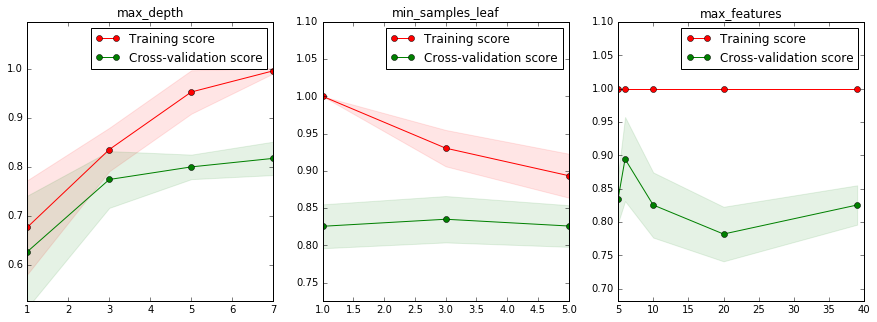

In [21]:
figure = plt.figure(figsize=(15, 5))
for i, param in enumerate(['max_depth', 'min_samples_leaf', 'max_features']):
    training_scores, validation_scores = validation_curve(DecisionTreeClassifier(random_state=2016,
                                                                                 class_weight='balanced'),
                                                          X_train, y_train,
                                                          param_name = param,
                                                          param_range = param_grid[param],
                                                          cv=5)
    
    figure.add_subplot(1, 3, i+1)
    plt.title(param)
    plot_validation_curve(param_grid[param], training_scores, validation_scores)

As can be seen from the above plots, none of the parameters are able to generalize and there is a huge amount of variance in the validation scores as seen from the standard deviation of the score. In order to reduce this variance, let us try to build a Random Forest model.

#### Random Forest Classifer

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10,
                            random_state=42)

rf.fit(X_train, y_train)

print classification_report(y_test, rf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94        25
        1.0       1.00      0.25      0.40         4

avg / total       0.91      0.90      0.87        29



Random forest also works quite well out of the box. However, we would like to get a proper estimate of generalization and hence we will cross validate the results in this section as well as tune the model.

In [23]:
rf_model= RandomForestClassifier(class_weight='balanced', random_state=999)

num_estimators = [5, 10, 20, 50]
leaf_size = [1, 3, 5]
max_features = [5, 6, 10, 20]
param_grid = {'n_estimators': num_estimators,
              'max_features': max_features,
              'min_samples_leaf':leaf_size}

rf_estimator = GridSearchCV(rf_model, param_grid, scoring="f1_macro", cv=10)

rf_estimator.fit(X_train, y_train)

print classification_report(y_test, rf_estimator.predict(X_test))

C:\Users\Prasun Srivastava\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.87      0.80      0.83        25
        1.0       0.17      0.25      0.20         4

avg / total       0.77      0.72      0.75        29



As we can see, the random forest model is working just okay. Let us check the best parameters for the model.

In [24]:
rf_estimator.best_params_

{'max_features': 6, 'min_samples_leaf': 5, 'n_estimators': 20}

Let us plot the learning curve for the model and see if the model has converged or it could have performed well with more data.

In [25]:
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")

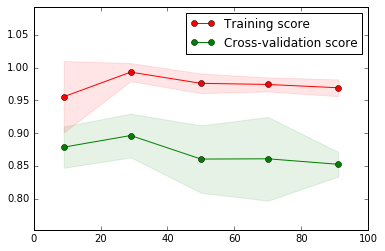

In [26]:
training_sizes, training_score, validation_score = learning_curve(RandomForestClassifier(class_weight='balanced',
                                                                                          max_features=10,
                                                                                          min_samples_leaf=3,
                                                                                          n_estimators=10), 
                                                                  X_train, y_train, cv=5)

plot_learning_curve(training_sizes, training_score, validation_score)

As we can see that there is a huge gap between the training and cross-validation score, we could do much better with more data. However, we do not have an option for the same. Let us check the top 10 predictors for our random forest model

In [29]:
# identify the indices for the sorted feature importance
idx = np.argsort(rf_estimator.best_estimator_.feature_importances_)
idx = idx[::-1] # sort in descending order by reversing the ascending order sorted list
idx = idx[:10] # pick only top 10
features = features_list[1:]
for feature, importance in zip(np.array(features)[idx], rf_estimator.best_estimator_.feature_importances_[idx]):
    print feature, ':', importance

exercised_stock_options : 0.161407497158
bonus : 0.139810149342
total_stock_value : 0.126617773141
total_payments : 0.126204052633
expenses : 0.117620856131
salary : 0.0675778634239
from_poi_to_this_person : 0.0638182974988
missing_deferred_income : 0.0534723020639
from_this_person_to_poi : 0.050810397838
from_messages : 0.0303346151772


Next, let us try a logistic regression model. Since, logistic regression models belong to linear models and are fairly fast to train, we are going to attemp the cross-validated hyperparameter tuning directly.

In [31]:
clf_lr = LogisticRegression(random_state=42, class_weight='balanced')

C = [10**num for num in range(-6, 6)]
param_grid = {'C':C, 'penalty':['l1', 'l2']}

estimator_lr = GridSearchCV(clf_lr, param_grid, cv=10, scoring='f1_macro')

estimator_lr.fit(X_train, y_train)

print classification_report(y_test, estimator_lr.predict(X_test))
print
print estimator_lr.best_params_

             precision    recall  f1-score   support

        0.0       0.95      0.76      0.84        25
        1.0       0.33      0.75      0.46         4

avg / total       0.86      0.76      0.79        29


{'penalty': 'l1', 'C': 10000}


As we can see, the logistic regression model has a high precision and recall than the random forest model. Also, it has a higher overall F1 score than the random forest model. 

In [32]:
print "Features Not used in model:\n"
for feature, coef in zip(features_list[1:], estimator_lr.best_estimator_.coef_[0]):
    if coef == 0.0:
        print feature

Features Not used in model:

missing_total_stock_value
missing_total_payments
missing_other
missing_salary
missing_restricted_stock


Since, Logistic Regression Models are fairly easy to train and the model performance is quite at par with the random forest model that we trained, I am going to select the Logistic Regression model as my final model. 